In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import norm
import scipy.stats as st

import warnings

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params); np.random.seed(0)
style.use('tableau-colorblind10')

#%matplotlib inline
tqdm.pandas()
warnings.filterwarnings('ignore')

# import plotly
# import plotly.figure_factory as ff
# import plotly.graph_objs as go 
# import plotly.express as px
# import plotly.offline as pyo
# from plotly.subplots import make_subplots
#pyo.init_notebook_mode()

# Load & Pre-process Datasets

This procedures are essential to conduct our main analysis. 

1. Load `food` dataset which contains all 35.9M pairs of food pantry info and its BGs within 25 miles. We have created this dataset from the jupyter file `prepare_data_statistics.ipynb`. 
- There are 34,475 food pantries and banks (FPs) in the dataset. 

In [2]:
food = pd.read_pickle('../data/food_bg20_adi_st.pkl')

In [3]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35940827 entries, 0 to 35940826
Data columns (total 12 columns):
 #   Column         Dtype  
---  ------         -----  
 0   address        object 
 1   ad_lat         float64
 2   ad_lon         float64
 3   ad_bg_fips     object 
 4   bg_fips        object 
 5   bg_lat         float64
 6   bg_lon         float64
 7   distance_mi    float64
 8   ADI_NATRANK    int64  
 9   ADI_STATERNK   int64  
 10  bg_state       object 
 11  address_state  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 3.2+ GB


In [4]:
food.address.nunique()

34475

2. Load `bg` dataset (the original ADI dataset from UW Madison's Neighborhood Atlas). This dataset will be mainly used for filtering BGs that do have FPs within 25 miles or not. 

- `bg_cont`: BGs in the continental U.S -> a total of 239,780 BGs in 50 states and the DC.

In [5]:
bg = pd.read_csv('../data/US_2020_ADI_Census Block Group_v3.2.csv',
                dtype={'FIPS':str, 'ADI_NATRANK':str, 'ADI_STATERNK':str})
bg = bg[['FIPS', 'ADI_NATRANK', 'ADI_STATERNK']]
bg = bg.rename(columns={'FIPS':'bg_fips'})

In [6]:
bg_cont = bg.loc[(~bg.bg_fips.str.startswith('72')) 
             & (~bg.bg_fips.str.startswith('78'))
            & (~bg.bg_fips.str.startswith('69'))
            & (~bg.bg_fips.str.startswith('66'))
            & (~bg.bg_fips.str.startswith('60'))]

In [7]:
bg_cont.bg_fips.nunique()

239780

3. Find and merge the state/county info for each BG

- `find_sate_fips` retrieves the corresponding state information based on the first two digits of each BG's FIPS. 
- `us-state-fips.csv` contains all FIPS code of the 50 states and DC in the continental U.S.
- Note that the first two and five digits of each BG's FIPS indicate the BG's state and county, respectively. 

In [8]:
def find_state_fips(bg, state_data):
    
    st_fips = bg[:2]
    for i in range(len(state_data)):
        if state_data['st_fips'][i] == st_fips:            
            return state_data['st_abb'][i]

In [9]:
state_fips = pd.read_csv('../data/us-state-fips.csv',
                        dtype = {'stname':str, ' st':str, ' stusps':str})
state_fips = state_fips.rename(columns={'stname':'STATE', ' st':'st_fips', ' stusps':'st_abb'})
state_fips.st_abb = state_fips.st_abb.str.strip()
state_fips.st_fips = state_fips.st_fips.str.strip()

In [10]:
bg_cont['bg_state'] = bg_cont.progress_apply(lambda x:find_state_fips(x.bg_fips, state_fips), axis=1)
bg_cont['bg_county']  = bg_cont.progress_apply(lambda x:x.bg_fips[0:5], axis=1)

100%|██████████| 239780/239780 [00:03<00:00, 63676.14it/s]


4. Find each BG's rural status (based on RUCC 2013 Codes)
- `county_rurality`: the entire county-level dataset of RUCC 2013 codes from USDA ERS, where BGs in counties tagged with all subcategories within 'Metro' are considered as urban and all within 'Nonmetro' as rural. 

In [11]:
county_rurality = pd.read_csv('../data/ruralurbancodes2013.csv', 
                          dtype = {'FIPS':str})

county_rurality['RUCC_2013'] = county_rurality['RUCC_2013'].astype(str)
county_rurality.Description = county_rurality.Description.str.strip()

def decide_urban_degree(text):
    
    if text in ['Metro - Counties in metro areas of 250,000 to 1 million population',
       'Metro - Counties in metro areas of fewer than 250,000 population', 
               'Metro - Counties in metro areas of 1 million population or more']:
        
        return 'Metro'
    
    elif text in ['Nonmetro - Urban population of 20,000 or more, adjacent to a metro area', 
                  'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area']:
        return 'Nonmetro'
    
    elif text in ['Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area',
                  'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area']:
        return 'Nonmetro'
    
    elif text in ['Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area',
                  'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area']:
        return 'Nonmetro'
    else:
        return 'N/A'


county_rurality['status'] = county_rurality.apply(lambda x:decide_urban_degree(x.Description), axis=1)
county_rurality = county_rurality.rename(columns={'FIPS':'bg_county'})
county_rurality 

,bg_county,State,County_Name,Population_2010,RUCC_2013,Description,status
0,01001,AL,Autauga County,"54,571",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
1,01003,AL,Baldwin County,"182,265",3.0,Metro - Counties in metro areas of fewer than ...,Metro
2,01005,AL,Barbour County,"27,457",6.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro
3,01007,AL,Bibb County,"22,915",1.0,Metro - Counties in metro areas of 1 million p...,Metro
4,01009,AL,Blount County,"57,322",1.0,Metro - Counties in metro areas of 1 million p...,Metro
...,...,...,...,...,...,...,...
3229,72151,PR,Yabucoa Municipio,"37,941",1.0,Metro - Counties in metro areas of 1 million p...,Metro
3230,72153,PR,Yauco Municipio,"42,043",2.0,"Metro - Counties in metro areas of 250,000 to ...",Metro
3231,78010,VI,St. Croix Island,"50,601",5.0,"Nonmetro - Urban population of 20,000 or more,...",Nonmetro
3232,78020,VI,St. John Island,"4,170",7.0,"Nonmetro - Urban population of 2,500 to 19,999...",Nonmetro


5. Merge `bg_cont` with the `county_rurality` information, resulting in a dataset of all block groups' FIPS code, their ADI, state/county, and urban/rural status. 

In [12]:
bg_cont = bg_cont.merge(county_rurality[['bg_county', 'status']].drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

In [13]:
bg_cont

,bg_fips,ADI_NATRANK,ADI_STATERNK,bg_state,bg_county,status
0,010010201001,73,5,AL,01001,Metro
1,010010201002,62,3,AL,01001,Metro
2,010010202001,83,7,AL,01001,Metro
3,010010202002,87,7,AL,01001,Metro
4,010010203001,73,5,AL,01001,Metro
...,...,...,...,...,...,...
239775,560459511001,65,8,WY,56045,Nonmetro
239776,560459511002,49,6,WY,56045,Nonmetro
239777,560459513001,85,10,WY,56045,Nonmetro
239778,560459513002,70,9,WY,56045,Nonmetro


6. (Optional) Split all 239,780 BGs in the continental U.S. into two distinct groups: 

(1) `bg_yes_pantry` (232,735 BGs that do have at least one food pantry (FP) ≤ 25 miles), 

(2) `bg_no_pantry` (7,045 BGs that do not have any FPs ≤ 25 miles). Note that only 1,145 BGs out of 7,045 BGs that do not have FPs ≤ 25 miles show valid (e.g., non-missing and numeric) national ADI percentile values. 

In [14]:
bg_with_fp = food.bg_fips.unique() # All BGs in our dataset that are identified as having at least a FP < 25 miles 

In [15]:
bg_yes_pantry = bg_cont.loc[(bg_cont.bg_fips.isin(bg_with_fp))
            & (bg_cont['ADI_NATRANK'].isna()==False)
            & (bg_cont['ADI_NATRANK'].str.isnumeric())].reset_index(drop=True)

bg_yes_pantry['ADI_NATRANK'] = bg_yes_pantry['ADI_NATRANK'].astype(int)

In [16]:
bg_no_pantry = bg_cont.loc[(~bg_cont.bg_fips.isin(bg_with_fp))
            & (bg_cont['ADI_NATRANK'].isna()==False)
            & (bg_cont['ADI_NATRANK'].str.isnumeric())].reset_index(drop=True)

bg_no_pantry['ADI_NATRANK'] = bg_no_pantry['ADI_NATRANK'].astype(int)

Now, it's time to pre-process the accessibility dataset. 

7. Pre-process the accessibility dataset

`bg_access`: the dataset that we created from `compute_travel_time.ipynb` file, which consists of all information about each BG and its nearest FP, along with distance/travel time between them, ADI and state info. 

In [17]:
bg_access = pd.read_csv('../data/bg_transit_adi.csv', dtype={'bg_fips':str})

In [18]:
bg_access = bg_access[['bg_fips', 'address', 'distance_mi', 'ADI_NATRANK', 'ADI_STATERNK', 
                        'bg_state', 'address_state' ,'transit_time', 'walking_time']]

In [19]:
bg_access.head()

,bg_fips,address,distance_mi,ADI_NATRANK,ADI_STATERNK,bg_state,address_state,transit_time,walking_time
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,73,5,AL,AL,20.08,20.08
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,62,3,AL,AL,37.30,37.30
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,83,7,AL,AL,20.33,20.33
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,87,7,AL,AL,8.40,8.40
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,73,5,AL,AL,42.63,42.63


8. Merge with `bg_county` and `status` (rural or urban) information for each BG

In [20]:
bg_access['bg_county'] = bg_access.progress_apply(lambda x:x.bg_fips[:5], axis=1)

100%|██████████| 232735/232735 [00:03<00:00, 65147.48it/s]


In [21]:
bg_access = bg_access.merge(county_rurality[['bg_county', 'status']].drop_duplicates(subset=['bg_county']), how='left', on='bg_county')

Because `bg_access` contains only 232,735 BGs that do have FPs ≤ 25 miles so that we can compute travel time, we also include the other BGs in `bg_no_pantry` that do not have FPs ≤ 25 miles to update `bg_access`.

In [22]:
bg_access = pd.concat([bg_access, bg_cont.loc[(~bg_cont.bg_fips.isin(bg_with_fp))]])

In [23]:
bg_access

,bg_fips,address,distance_mi,ADI_NATRANK,ADI_STATERNK,bg_state,address_state,transit_time,walking_time,bg_county,status
0,010010201001,"203 N Court St, Prattville, AL 36067",0.835864,73,5,AL,AL,20.08,20.08,01001,Metro
1,010010201002,"203 N Court St, Prattville, AL 36067",1.684913,62,3,AL,AL,37.30,37.30,01001,Metro
2,010010202001,"203 N Court St, Prattville, AL 36067",1.065305,83,7,AL,AL,20.33,20.33,01001,Metro
3,010010202002,"203 N Court St, Prattville, AL 36067",0.327409,87,7,AL,AL,8.40,8.40,01001,Metro
4,010010203001,"203 N Court St, Prattville, AL 36067",1.367486,73,5,AL,AL,42.63,42.63,01001,Metro
...,...,...,...,...,...,...,...,...,...,...,...
239768,560430002003,NaN,NaN,47,5,WY,NaN,NaN,NaN,56043,Nonmetro
239776,560459511002,NaN,NaN,49,6,WY,NaN,NaN,NaN,56045,Nonmetro
239777,560459513001,NaN,NaN,85,10,WY,NaN,NaN,NaN,56045,Nonmetro
239778,560459513002,NaN,NaN,70,9,WY,NaN,NaN,NaN,56045,Nonmetro


Based on our definition of accessibility, we compute shorter travel time to measure accessibility, by the least travel time by transit or walking. This is stored in the `access` column. 

In [24]:
def shorter_travel(transit, walk):
    travel = 0
    if np.isnan(transit) == False:
        if np.isnan(walk) == False:
            if transit >= walk: # transit 0 walk 0
                travel = walk
            else:
                travel = transit
        else: # transit 0 walk x
            travel = transit
    else: #transit x
        if np.isnan(walk) == False: # transit x walk 0
            travel = walk
        else:
            travel = None # transit x walk x

    return travel

In [25]:
bg_access['access'] = bg_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 239780/239780 [00:08<00:00, 28971.67it/s]


In [26]:
def isnumber(x): # convert all ADI to its numeric format
    try:
        d = int(x)
        return d
    except:
        return None


bg_access['ADI_NATRANK'] = bg_access.progress_apply(lambda x:isnumber(x.ADI_NATRANK), axis=1)

100%|██████████| 239780/239780 [00:04<00:00, 57131.04it/s]


Then, we have all 239,780 BGs in the continental U.S., along with their accessibility information!

-------------------------------------------------------------------------------------------

# Table 1

## (1) Characteristics of Total 239,780 BGs

In [27]:
print('1. Total number of BGs: ', len(bg_access))
print('----------------------------')

print('2. Number of FPs by rural status')
print(bg_access.status.value_counts(normalize=False))
print(bg_access.status.value_counts(normalize=True))
print('----------------------------')

print('3. Mean of national ADI percentiles')
print('Mean: ', np.mean(bg_access.ADI_NATRANK))
print('SD: ', np.std(bg_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((bg_access.ADI_NATRANK)), 
                                   scale=st.sem((bg_access.ADI_NATRANK), nan_policy='omit')))

print('----------------------------')

print('4. Mean of Travel time (accessibility)')
print('Mean: ', np.mean(bg_access.access))
print('SD: ', np.std(bg_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((bg_access.access)), 
                                   scale=st.sem(bg_access.access, nan_policy = 'omit')))

1. Total number of BGs:  239780
----------------------------
2. Number of FPs by rural status
Metro       198767
Nonmetro     40995
Name: status, dtype: int64
Metro       0.829018
Nonmetro    0.170982
Name: status, dtype: float64
----------------------------
3. Mean of national ADI percentiles
Mean:  50.11550877132974
SD:  28.741238580189798
95% CI:  (49.9990287456967, 50.23198879696279)
----------------------------
4. Mean of Travel time (accessibility)
Mean:  78.56219881752156
SD:  338.00597525649135
95% CI:  (77.18779543676037, 79.93660219828412)


## (2) Level of Accessibility

Here's the definitions of "Easy, Difficult, or No accessibility" between a BG and its nearest food pantry by either public transit or walking. 

<div align="center">

| Transit 	| Walking 	| **Easy/Diff/No?** 	|
|---------	|---------	|-------------------	|
| N     	| N       	| No                	|
| N       	| <= 20   	| Easy              	|
| N       	| > 20    	| Difficult         	|
| <= 40   	| N       	| Easy              	|
| > 40    	| N       	| Difficult         	|
| <= 40   	| <= 20   	| Easy              	|
| <= 40   	| > 20    	| Easy              	|
| > 40    	| <= 20   	| Easy              	|
| > 40    	| > 20    	| Difficult         	|
</div>

In [28]:
easy_access = pd.concat([bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time <= 20)], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time.isna())], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time <= 20)], 
                        bg_access.loc[(bg_access.transit_time <= 40) & (bg_access.walking_time > 20)], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time <= 20)]], ignore_index=True)

easy_access['access'] = easy_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 125835/125835 [00:04<00:00, 28238.18it/s]


### `easy_access` in Table 1

In [29]:
print('1. total # BGs in easy access: ', len(easy_access))
print('total % BGs in easy access: ', len(easy_access)/len(bg_access))
print('--------------------------------------------')

print('2. Number of BGs by rurality status')
print(easy_access.status.value_counts(normalize=False))
print(easy_access.status.value_counts(normalize=True))
print('--------------------------------------------')

print('3. Statistics of national ADI percentiles')
print('Mean: ', np.mean(easy_access.ADI_NATRANK))
print('SD: ', np.std(easy_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((easy_access.ADI_NATRANK)), 
                                   scale=st.sem((easy_access.ADI_NATRANK))))
print('--------------------------------------------')

print('4. Statistic of travel time (accessibility)')
print('Mean: ', np.mean(easy_access.access))
print('SD: ', np.std(easy_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((easy_access.access)), 
                                   scale=st.sem((easy_access.access))))

print('--------------------------------------------')

1. total # BGs in easy access:  125835
total % BGs in easy access:  0.5247935607640337
--------------------------------------------
2. Number of BGs by rurality status
Metro       115796
Nonmetro     10039
Name: status, dtype: int64
Metro       0.920221
Nonmetro    0.079779
Name: status, dtype: float64
--------------------------------------------
3. Statistics of national ADI percentiles
Mean:  49.77993404060874
SD:  30.146372620973075
95% CI:  (49.61336888577852, 49.94649919543895)
--------------------------------------------
4. Statistic of travel time (accessibility)
Mean:  19.454401796002657
SD:  10.161520878355269
95% CI:  (19.39825722034528, 19.510546371660034)
--------------------------------------------


In [30]:
diff_access = pd.concat([bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time > 20)], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time.isna())], 
                        bg_access.loc[(bg_access.transit_time > 40) & (bg_access.walking_time > 20)]], ignore_index=True)

diff_access['access'] = diff_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 106502/106502 [00:03<00:00, 30998.04it/s]


### `diff_access` in Table 1

In [31]:
print('1. total # BGs in diff access: ', len(diff_access))
print('total % BGs in diff access: ', len(diff_access)/len(bg_access))
print('--------------------------------------------')

print('2. Number of BGs by rurality status')
print(diff_access.status.value_counts(normalize=False))
print(diff_access.status.value_counts(normalize=True))
print('--------------------------------------------')

print('3. Statistics of national ADI percentiles')
print('Mean: ', np.mean(diff_access.ADI_NATRANK))
print('SD: ', np.std(diff_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((diff_access.ADI_NATRANK)), 
                                   scale=st.sem((diff_access.ADI_NATRANK))))
print('--------------------------------------------')

print('4. Statistic of travel time (accessibility)')
print('Mean: ', np.mean(diff_access.access))
print('SD: ', np.std(diff_access.access))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.mean((diff_access.access)), 
                                   scale=st.sem((diff_access.access))))

print('--------------------------------------------')

1. total # BGs in diff access:  106502
total % BGs in diff access:  0.4441654850279423
--------------------------------------------
2. Number of BGs by rurality status
Metro       77592
Nonmetro    28909
Name: status, dtype: int64
Metro       0.728557
Nonmetro    0.271443
Name: status, dtype: float64
--------------------------------------------
3. Statistics of national ADI percentiles
Mean:  50.315956507859006
SD:  26.952144205094065
95% CI:  (50.15408717759038, 50.477825838127636)
--------------------------------------------
4. Statistic of travel time (accessibility)
Mean:  148.39966326140998
SD:  490.00814713024533
95% CI:  (145.45676973878054, 151.34255678403943)
--------------------------------------------


### `no_access` in Table 1

Note that `no_access` has no information about travel time (accessibility) as they do not have FPs ≤ 25 miles or do not have avaialble transit/walking routes to visit FPs ≤ 25 miles.

In [32]:
no_access = bg_access.loc[(bg_access.transit_time.isna()) & (bg_access.walking_time.isna())]
no_access['access'] = no_access.progress_apply(lambda x:shorter_travel(x.transit_time, x.walking_time), axis=1)

100%|██████████| 7443/7443 [00:00<00:00, 28523.56it/s]


In [33]:
print('1. total # BGs in no access: ', len(no_access))
print('total % BGs in no access: ', len(no_access)/len(bg_access))
print('--------------------------------------------')

print('2. Number of BGs by rurality status')
print(no_access.status.value_counts(normalize=False))
print(no_access.status.value_counts(normalize=True))
print('--------------------------------------------')

print('3. Statistics of national ADI percentiles')
print('Mean: ', np.mean(no_access.ADI_NATRANK))
print('SD: ', np.std(no_access.ADI_NATRANK))

print('95% CI: ', st.norm.interval(alpha=0.95, 
                                   loc=np.nanmean((no_access.ADI_NATRANK)), 
                                   scale=st.sem((no_access.ADI_NATRANK), nan_policy='omit')))

1. total # BGs in no access:  7443
total % BGs in no access:  0.03104095420802402
--------------------------------------------
2. Number of BGs by rurality status
Metro       5379
Nonmetro    2047
Name: status, dtype: int64
Metro       0.724347
Nonmetro    0.275653
Name: status, dtype: float64
--------------------------------------------
3. Statistics of national ADI percentiles
Mean:  63.5858064516129
SD:  27.596354220895154
95% CI:  (62.21153003769133, 64.96008286553447)


# Figure 1

## (a) National ADI distribution among three accessibility groups

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '[1-10]'),
  Text(1, 0, '[11-20]'),
  Text(2, 0, '[21-30]'),
  Text(3, 0, '[31-40]'),
  Text(4, 0, '[41-50]'),
  Text(5, 0, '[51-60]'),
  Text(6, 0, '[61-70]'),
  Text(7, 0, '[71-80]'),
  Text(8, 0, '[81-90]'),
  Text(9, 0, '[91-100]')])

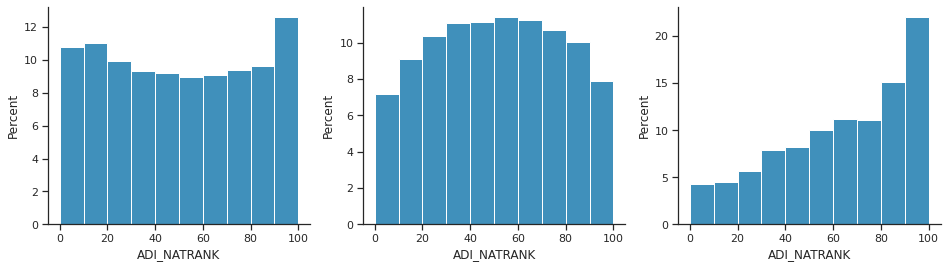

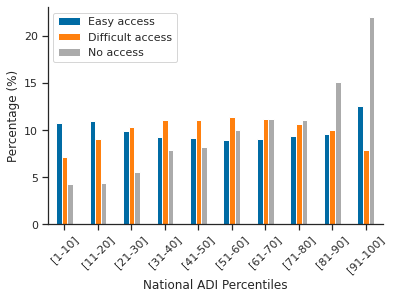

In [41]:
fig, axes = plt.subplots(1, 3,  figsize=(16, 4))
fig.subplots_adjust(hspace = 0.4)

e = sns.histplot(ax=axes[0], data=easy_access.ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))

d = sns.histplot(ax=axes[1], data=diff_access.ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))

n = sns.histplot(ax=axes[2], data=no_access.ADI_NATRANK, stat='percent', 
            bins=np.arange(0, 101, 10))


# Get heights of each bin
e_heights = [h.get_height() for h in e.patches]
d_heights = [h.get_height() for h in d.patches]
n_heights = [h.get_height() for h in n.patches]

pd.DataFrame({'Easy access':e_heights, 
              'Difficult access':d_heights,
              'No access': n_heights}, index=['[1-10]', '[11-20]', '[21-30]', '[31-40]', '[41-50]', '[51-60]', '[61-70]', '[71-80]', '[81-90]', '[91-100]']).plot.bar(rot=0)
plt.xlabel('National ADI Percentiles')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)


## (b) Accessibility type at U.S. county level

We create a dataset `access_type_county_df`, consisting of each U.S. county's accessibility type. Note that accessibility to FPs in each county was assigned by the dominant category of the three accessibility groups in that county. 

In [43]:
easy_access['type'] = 'Easy access'
diff_access['type'] = 'Difficult access'
no_access['type'] = 'No access'

typed_bg_access = pd.concat([easy_access, diff_access, no_access]).reset_index(drop=True)

In [44]:
county_fips = typed_bg_access.groupby(['bg_county']).type.value_counts(normalize=True).unstack().idxmax(axis=1).to_frame().index.tolist()
access_type_county = typed_bg_access.groupby(['bg_county']).type.value_counts(normalize=True).unstack().idxmax(axis=1).to_frame().unstack().tolist()

access_type_county_df = pd.DataFrame(list(zip(county_fips, access_type_county)), columns =['county_fips', 'type_of_accessibility'])
access_type_county_df['county_state'] = access_type_county_df.progress_apply(lambda x:find_state_fips(x.county_fips, state_fips), axis=1)

100%|██████████| 3143/3143 [00:00<00:00, 5904.22it/s] 


In [45]:
access_type_county_df.head()

,county_fips,type_of_accessibility,county_state
0,01001,Difficult access,AL
1,01003,Difficult access,AL
2,01005,Difficult access,AL
3,01007,Difficult access,AL
4,01009,Difficult access,AL


Save `access_type_county_df` to plot in Tableau. 

In [1]:
#access_type_county_df.to_csv('../data/access_type_county_df.csv', index=False)